# Run STIMP

In [1]:
import torch
import numpy as np 
import sys
import os
from dataset.dataset_imputation import PRE8dDataset

In [2]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='PRE', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])

**Fig 3b**

Text(0.4, 0.92, 'PCC=0.9960')

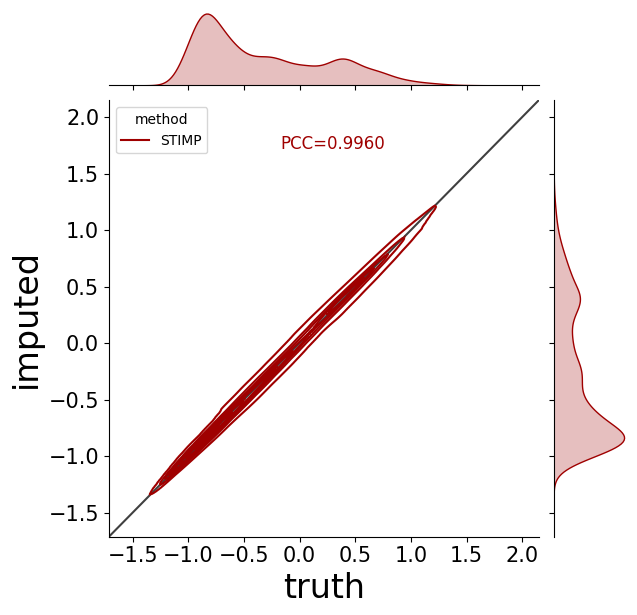

In [3]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.1.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_our,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:39:32.140 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 187: 0.0019914316944777966, 9.987736120820045e-06


Text(0.4, 0.92, 'PCC=0.9094')

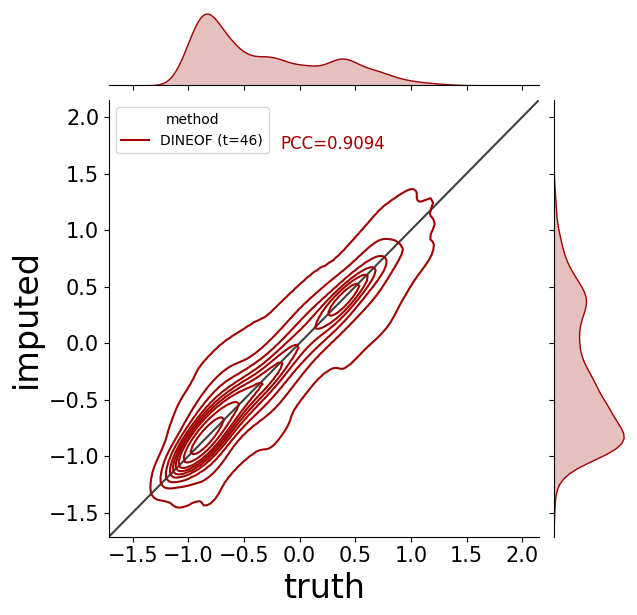

In [4]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()
model.fit(tmp_data)

imputed_data = model.predict()
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=46)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:39:42.556 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 77: 0.0026193836238235235, 9.065261110663414e-06
2025-06-03 14:39:42.811 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 72: 0.0014016376808285713, 9.566894732415676e-06
2025-06-03 14:39:42.988 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 67: 0.0008826245903037488, 9.261711966246367e-06
2025-06-03 14:39:43.147 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 69: 0.0005015823990106583, 9.681680239737034e-06
2025-06-03 14:39:43.248 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 34: 0.000318384263664484, 9.886338375508785e-06
2025-06-03 14:39:43.268 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 1.001445326664907e-07, 1.001445326664907e-07
2025-06-03 14:39:43.440 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 68: 0.0011385581456124783, 9.389128535985947e-06
2

Text(0.4, 0.92, 'PCC=0.7522')

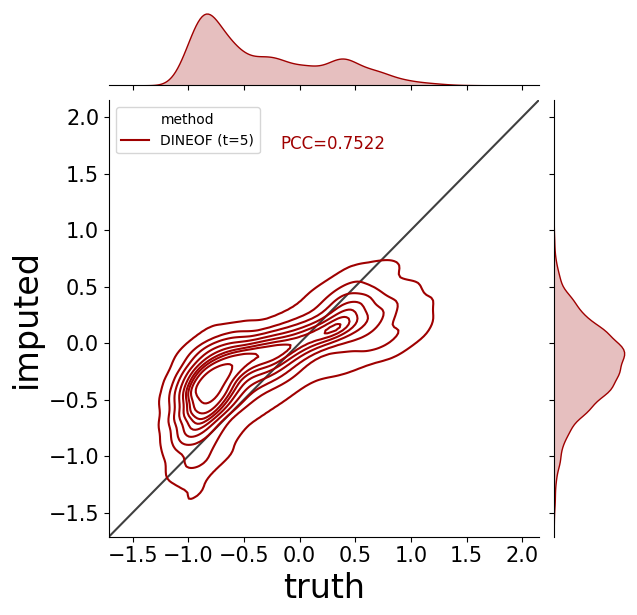

In [5]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(4, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=5
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=5)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:39:53.557 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 92: 0.0008462776313535869, 9.692506864666939e-06
2025-06-03 14:39:54.342 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 79: 0.0003628540434874594, 9.699346264824271e-06
2025-06-03 14:39:54.367 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 2.0300009850870993e-07, 2.0300009850870993e-07
2025-06-03 14:39:55.027 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 73: 0.0006849292549304664, 9.863113518804312e-06


Text(0.4, 0.92, 'PCC=0.8131')

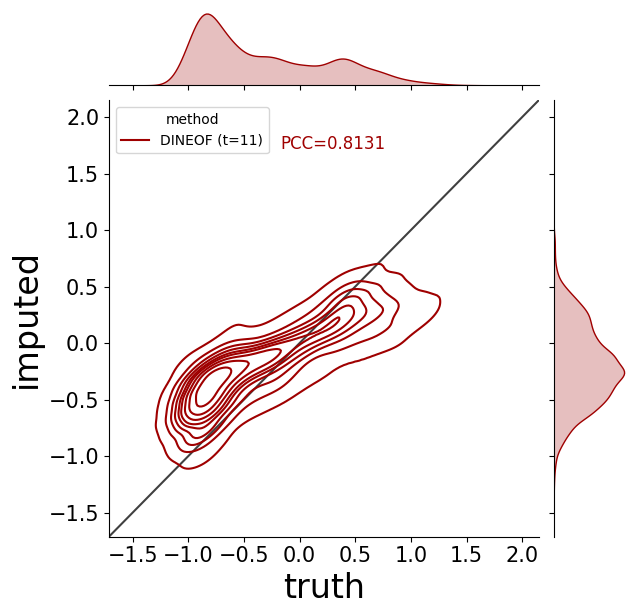

In [6]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=11
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=11)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:40:05.888 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 173: 0.0021644565276801586, 9.856652468442917e-06
2025-06-03 14:40:08.135 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 153: 0.00187805260065943, 9.957118891179562e-06


Text(0.4, 0.92, 'PCC=0.7706')

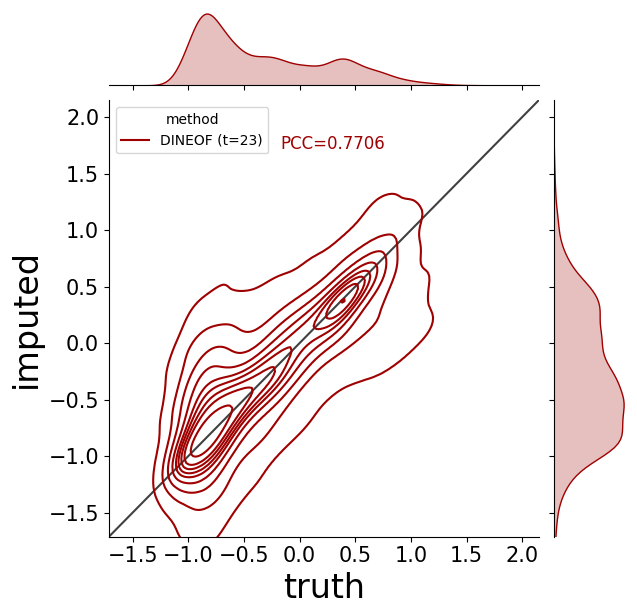

In [7]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=23
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=23)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:40:16.510 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 20: 0.003975672647356987, 1.2898817658424377e-07
2025-06-03 14:40:16.684 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 161: 0.0020144523587077856, 9.949551895260811e-06
2025-06-03 14:40:16.866 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 178: 0.0018819323740899563, 9.995768778026104e-06
2025-06-03 14:40:17.049 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 178: 0.0022644158452749252, 9.86829400062561e-06
2025-06-03 14:40:17.203 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 153: 0.002110376488417387, 9.974930435419083e-06
2025-06-03 14:40:17.310 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 106: 0.004458888433873653, 9.761657565832138e-06
2025-06-03 14:40:17.498 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative E

Text(0.4, 0.92, 'PCC=0.9877')

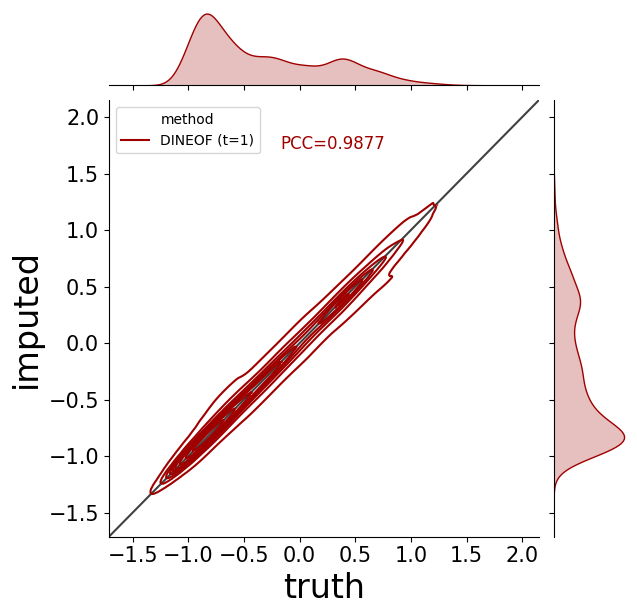

In [8]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=1)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

Text(0.4, 0.92, 'PCC=0.9929')

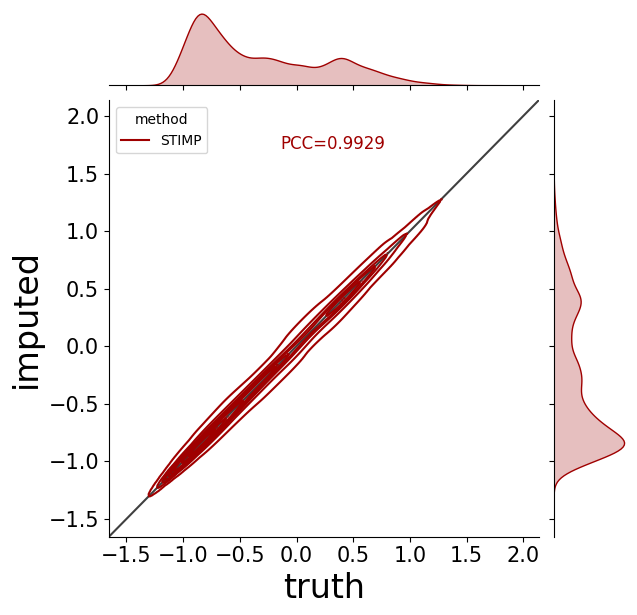

In [9]:
config.missing_ratio=0.3
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.3.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_our,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:41:20.321 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 155: 0.0017548399046063423, 9.990297257900238e-06


Text(0.4, 0.92, 'PCC=0.8779')

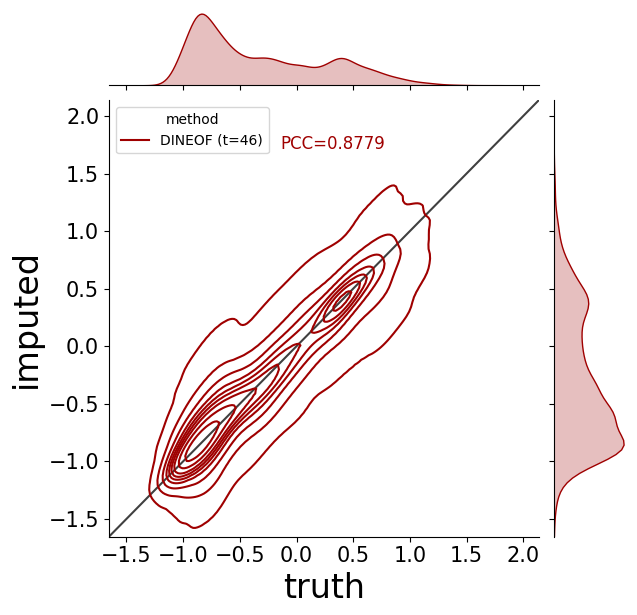

In [10]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()
model.fit(tmp_data)

imputed_data = model.predict()
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=46)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:41:48.607 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 53: 0.0027655723970383406, 9.028706699609756e-06
2025-06-03 14:41:48.825 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 74: 0.0006474465481005609, 9.669165592640638e-06
2025-06-03 14:41:48.928 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 35: 0.0010408916277810931, 6.753136403858662e-06
2025-06-03 14:41:49.083 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 57: 0.0010452123824506998, 9.997398592531681e-06
2025-06-03 14:41:49.186 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 37: 0.0003766003646887839, 9.427341865375638e-06
2025-06-03 14:41:49.205 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 6.371696059659371e-08, 6.371696059659371e-08
2025-06-03 14:41:49.297 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 33: 0.0015013111988082528, 7.3642004281282425e-06

Text(0.4, 0.92, 'PCC=0.7057')

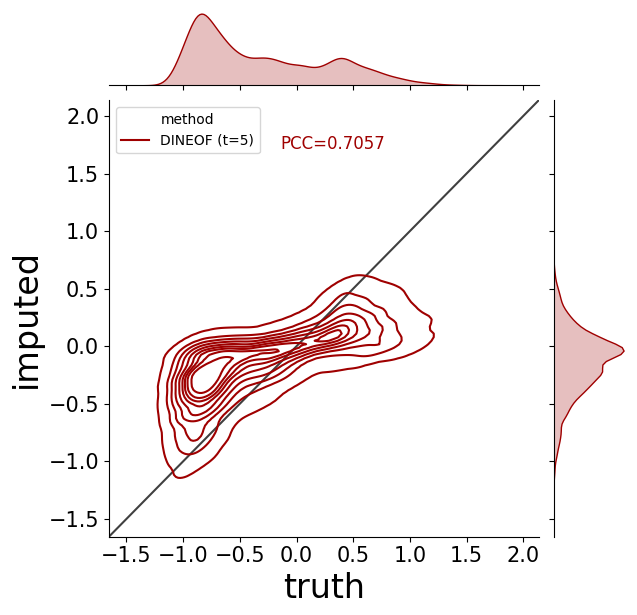

In [11]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(4, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=5
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=5)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:42:18.213 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 31: 0.0011603409657254815, 9.620096534490585e-06
2025-06-03 14:42:18.945 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 72: 0.0003450763178989291, 9.726471034809947e-06
2025-06-03 14:42:18.970 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 2.0481138562900014e-07, 2.0481138562900014e-07
2025-06-03 14:42:19.449 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 47: 0.0004008303221780807, 9.724462870508432e-06


Text(0.4, 0.92, 'PCC=0.7840')

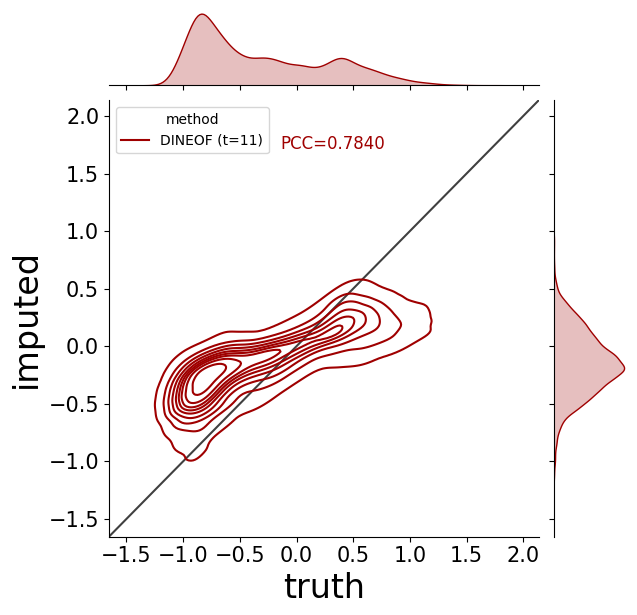

In [12]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=11
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=11)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:42:47.936 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 161: 0.0018636604072526097, 9.829876944422722e-06
2025-06-03 14:42:51.022 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 134: 0.0013445770600810647, 9.900075383484364e-06


Text(0.4, 0.92, 'PCC=0.7324')

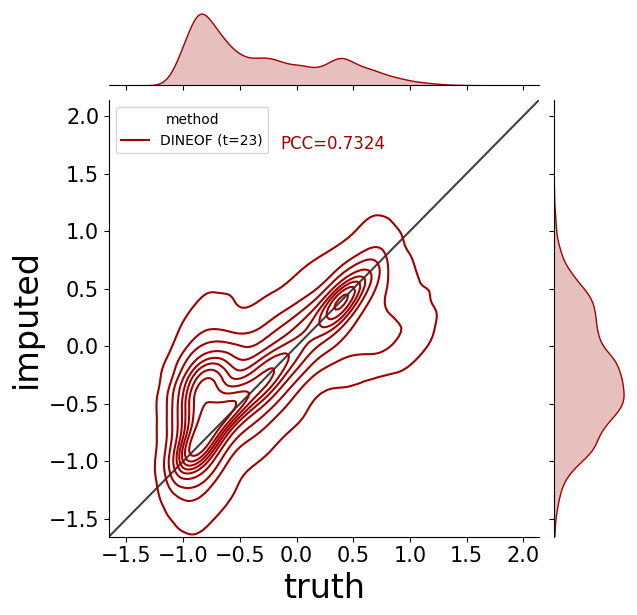

In [13]:
# DINEO
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=23
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=23)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:43:17.904 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 48: 0.004655675962567329, 8.131377398967743e-06
2025-06-03 14:43:18.071 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 160: 0.0019928442779928446, 9.9940225481987e-06
2025-06-03 14:43:18.226 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 148: 0.002047802321612835, 9.770272299647331e-06
2025-06-03 14:43:18.394 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 163: 0.002119346521794796, 9.896466508507729e-06
2025-06-03 14:43:18.551 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 152: 0.0017108683241531253, 9.92603600025177e-06
2025-06-03 14:43:18.728 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 172: 0.0022290218621492386, 9.857118129730225e-06
2025-06-03 14:43:18.876 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Erro

Text(0.4, 0.92, 'PCC=0.9678')

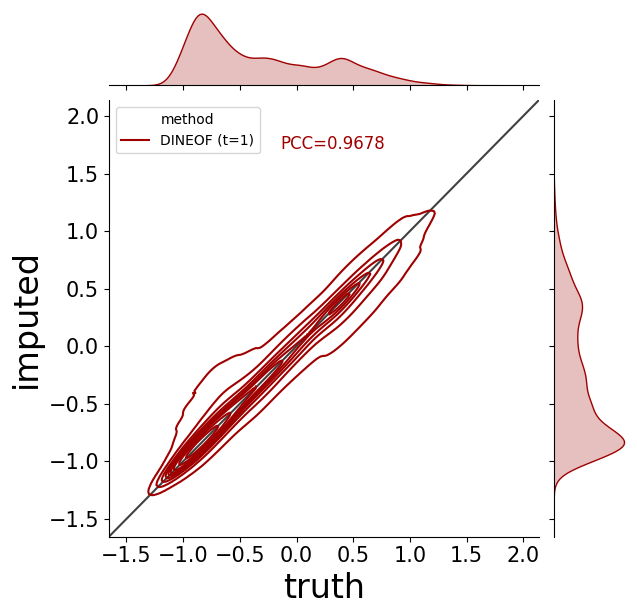

In [14]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=1)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

Text(0.4, 0.92, 'PCC=0.9869')

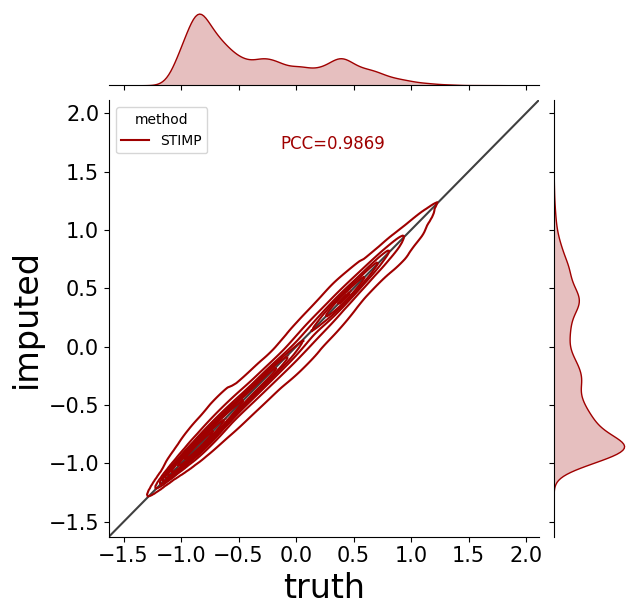

In [15]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.5.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_our,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:44:57.624 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 144: 0.0018268038984388113, 9.925919584929943e-06


Text(0.4, 0.92, 'PCC=0.8193')

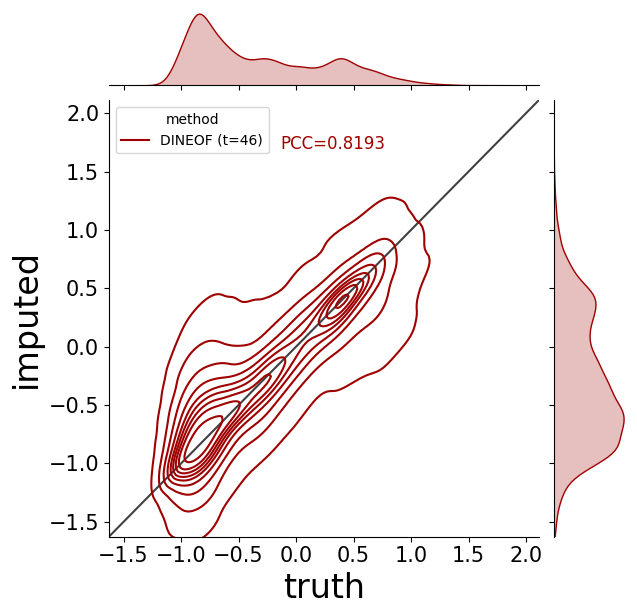

In [16]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()
model.fit(tmp_data)

imputed_data = model.predict()
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=46)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:45:42.085 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 78: 0.000733412045519799, 9.405659511685371e-06
2025-06-03 14:45:42.381 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 99: 0.00023820197384338826, 9.938448783941567e-06
2025-06-03 14:45:42.590 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 81: 0.00017151898646261543, 9.9015305750072e-06
2025-06-03 14:45:42.913 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 69: 0.0006918624276295304, 9.94885340332985e-06
2025-06-03 14:45:43.047 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 48: 0.00010128105350304395, 8.76635021995753e-06
2025-06-03 14:45:43.067 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 8.490124514537456e-08, 8.490124514537456e-08
2025-06-03 14:45:43.176 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 37: 0.00032473201281391084, 9.391078492626548e-06
2

Text(0.4, 0.92, 'PCC=0.6175')

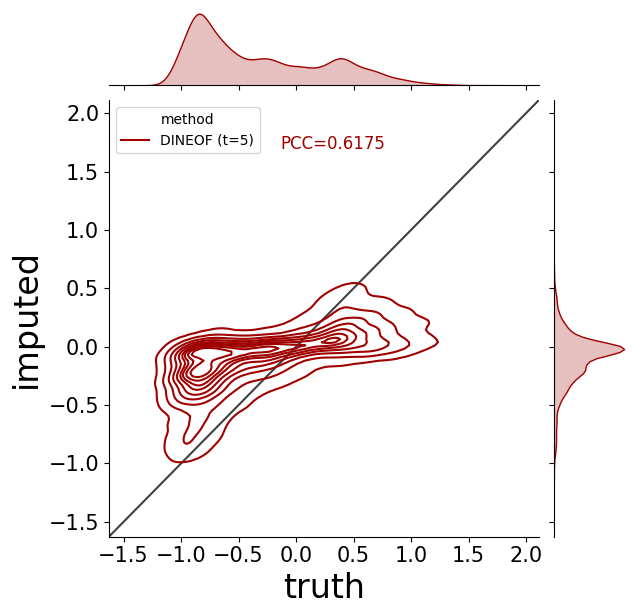

In [17]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(4, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=5
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=5)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:46:30.915 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 54: 0.0002735634334385395, 9.858689736574888e-06
2025-06-03 14:46:31.557 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 38: 0.0004660697595681995, 9.848095942288637e-06
2025-06-03 14:46:31.582 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 1.9639867332443828e-07, 1.9639867332443828e-07
2025-06-03 14:46:32.032 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 48: 0.00019795661501120776, 9.590163244865835e-06


Text(0.4, 0.92, 'PCC=0.7293')

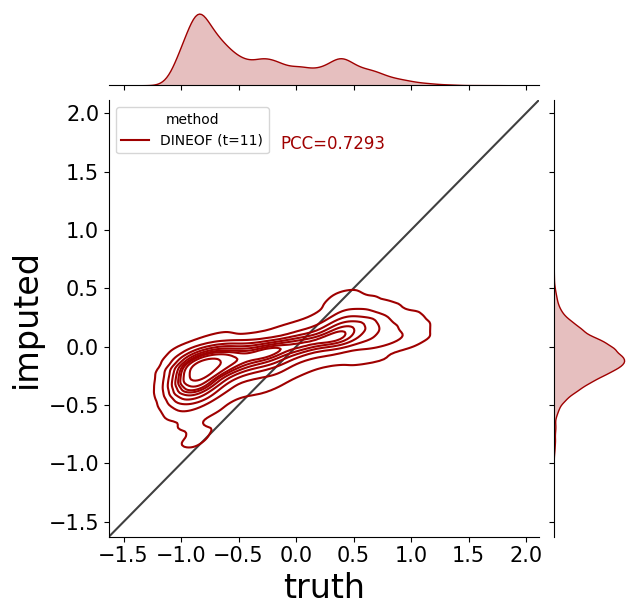

In [18]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=11
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=11)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:47:19.572 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 135: 0.0013060076162219048, 9.912531822919846e-06
2025-06-03 14:47:21.003 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 107: 0.0009507655631750822, 9.934999980032444e-06


Text(0.4, 0.92, 'PCC=0.6760')

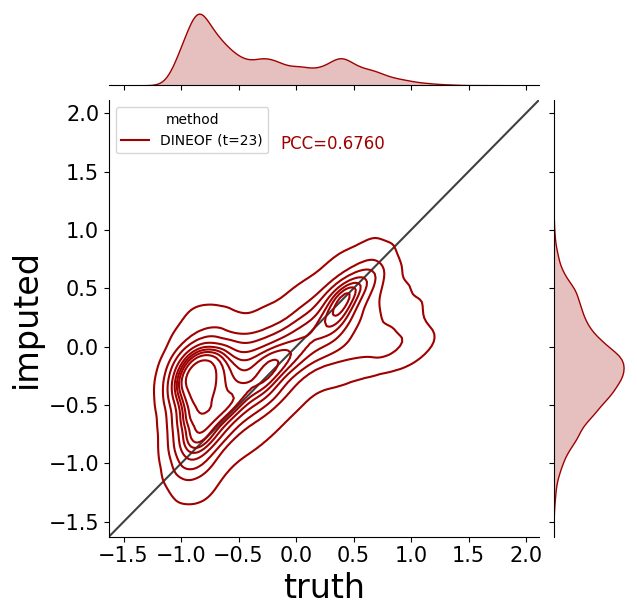

In [19]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=23
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=23)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:48:06.799 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 49: 0.005038238130509853, 6.91460445523262e-06
2025-06-03 14:48:06.957 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 148: 0.0013725385069847107, 9.842682629823685e-06
2025-06-03 14:48:07.113 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 145: 0.0017285357462242246, 9.748036973178387e-06
2025-06-03 14:48:07.241 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 119: 0.0015530084492638707, 9.872368536889553e-06
2025-06-03 14:48:07.383 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 134: 0.001610918203368783, 9.803683497011662e-06
2025-06-03 14:48:07.540 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 148: 0.0017730167601257563, 9.95490700006485e-06
2025-06-03 14:48:07.694 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Er

Text(0.4, 0.92, 'PCC=0.9018')

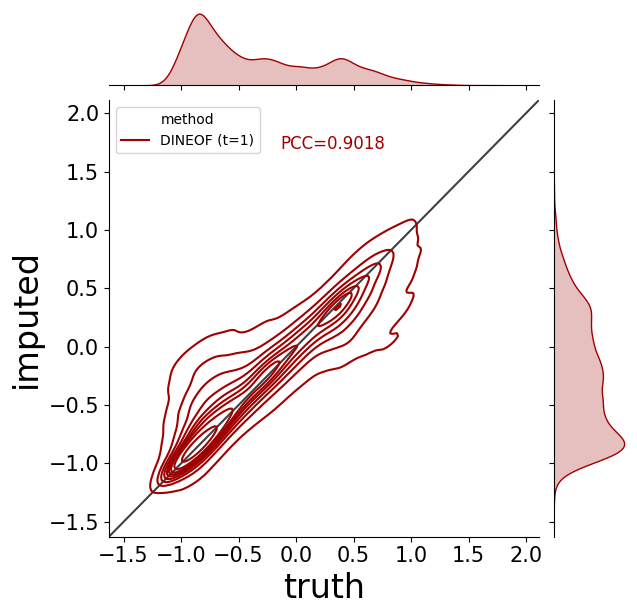

In [20]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=1)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

Text(0.4, 0.92, 'PCC=0.9738')

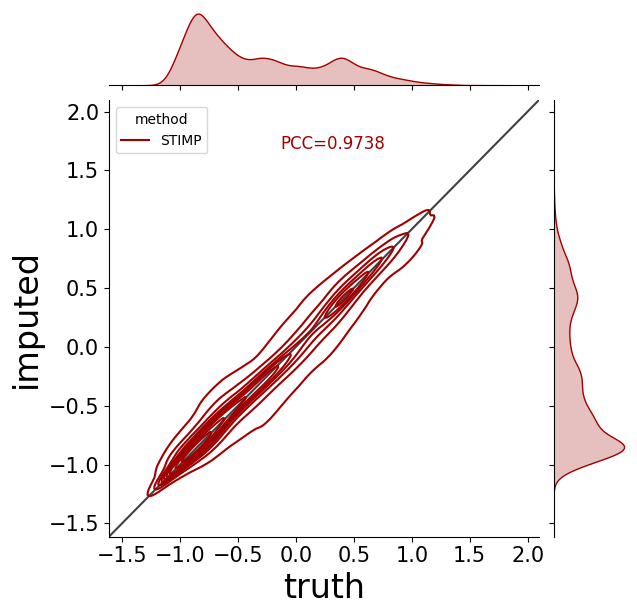

In [21]:
config.missing_ratio=0.7
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.7.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_our,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:50:21.186 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 134: 0.001426593167707324, 9.857118129730225e-06


Text(0.4, 0.92, 'PCC=0.6945')

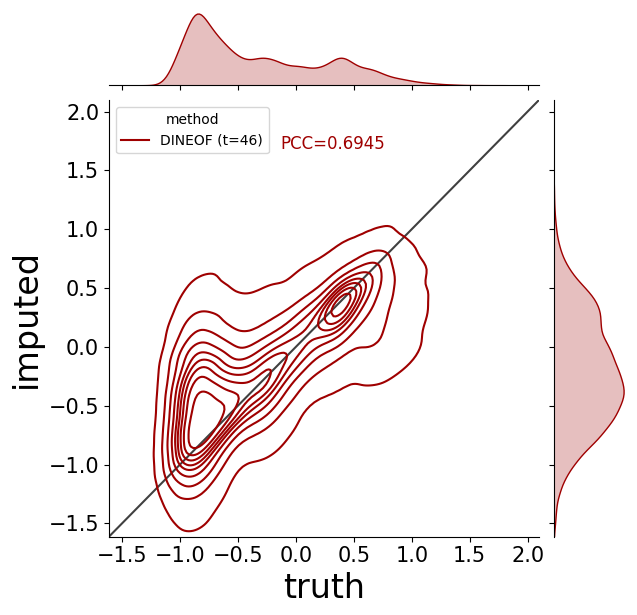

In [22]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()
model.fit(tmp_data)

imputed_data = model.predict()
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=46)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:51:23.631 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 33: 0.0009264986729249358, 8.64820322021842e-06
2025-06-03 14:51:23.698 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 14: 0.003838603151962161, 1.5683472156524658e-06
2025-06-03 14:51:23.855 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 66: 0.0001603393320692703, 9.902170859277248e-06
2025-06-03 14:51:23.923 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 22: 0.0005455789505504072, 7.616588845849037e-06
2025-06-03 14:51:23.974 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 13: 0.000480195099953562, 1.926033291965723e-06
2025-06-03 14:51:23.994 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 6.187770651422397e-08, 6.187770651422397e-08
2025-06-03 14:51:24.130 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 51: 0.0002570715150795877, 9.377283276990056e-06
20

Text(0.4, 0.92, 'PCC=0.5129')

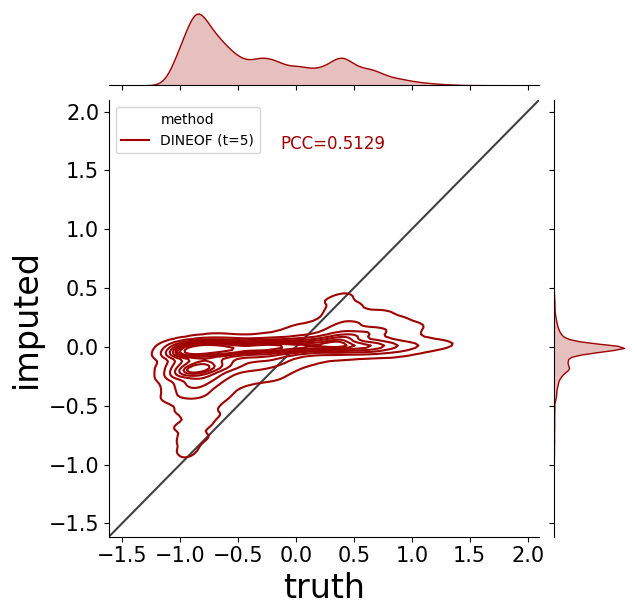

In [23]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(4, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=5
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=5)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:52:30.310 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 34: 8.404224354308099e-05, 9.235431207343936e-06
2025-06-03 14:52:30.568 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 32: 9.475122351432219e-05, 9.851901268120855e-06
2025-06-03 14:52:30.592 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 1.7444766342578077e-07, 1.7444766342578077e-07
2025-06-03 14:52:31.441 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 33: 0.00024325033882632852, 9.955605491995811e-06


Text(0.4, 0.92, 'PCC=0.6387')

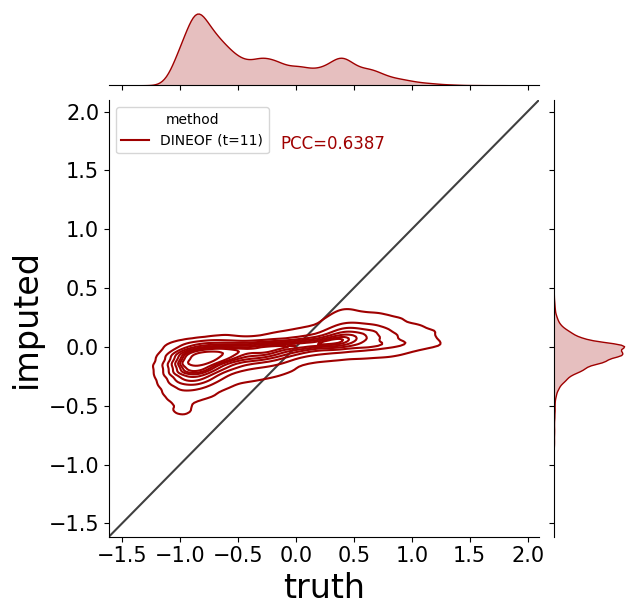

In [24]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=11
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=11)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:53:39.471 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 109: 0.0006985452491790056, 9.77847957983613e-06
2025-06-03 14:53:41.061 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 81: 0.00047964908299036324, 9.909301297739148e-06


Text(0.4, 0.92, 'PCC=0.5700')

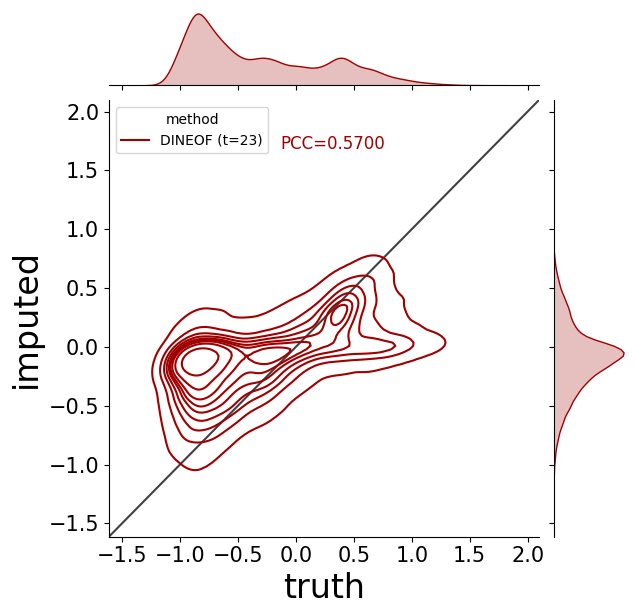

In [25]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=23
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=23)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:54:46.188 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 24: 0.0032232939265668392, 1.2076925486326218e-06
2025-06-03 14:54:46.312 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 115: 0.0009245204273611307, 9.892915841192007e-06
2025-06-03 14:54:46.442 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 122: 0.0013841711916029453, 9.749084711074829e-06
2025-06-03 14:54:46.586 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 137: 0.0011840699007734656, 9.8721357062459e-06
2025-06-03 14:54:46.722 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 129: 0.0011788735864683986, 9.977724403142929e-06
2025-06-03 14:54:46.860 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 132: 0.0011889883317053318, 9.866198524832726e-06
2025-06-03 14:54:46.999 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative

Text(0.4, 0.92, 'PCC=0.7228')

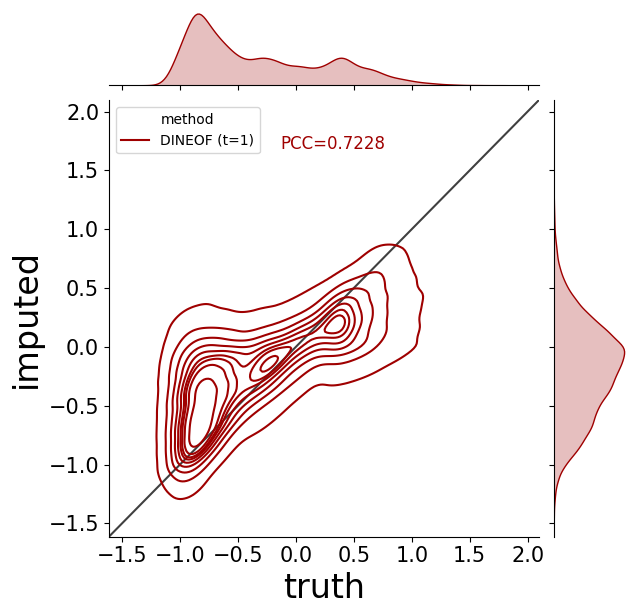

In [26]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=1)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

Text(0.4, 0.92, 'PCC=0.9454')

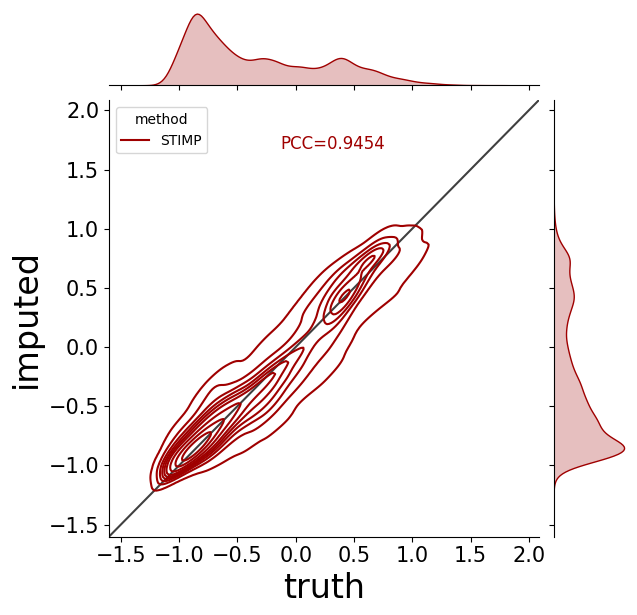

In [27]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.9.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_our,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:57:25.741 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 79: 0.00048423392581753433, 9.798997780308127e-06


Text(0.4, 0.92, 'PCC=0.4360')

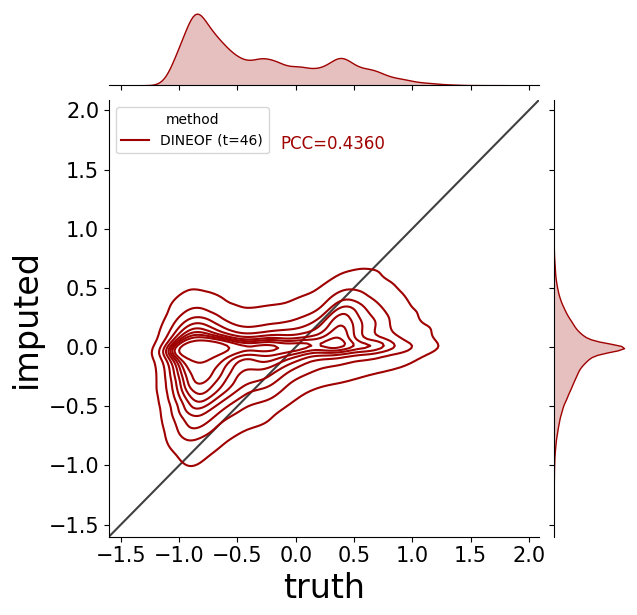

In [28]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()
model.fit(tmp_data)

imputed_data = model.predict()
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=46)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 14:58:46.056 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 33: 0.00011798148625530303, 9.892784873954952e-06
2025-06-03 14:58:46.226 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 44: 0.00010314747487427667, 9.284027328249067e-06
2025-06-03 14:58:46.374 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 40: 9.238488564733416e-05, 9.67855885392055e-06
2025-06-03 14:58:46.480 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 31: 0.00014137984544504434, 9.723618859425187e-06
2025-06-03 14:58:46.524 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 13: 0.00020046990539412946, 3.7585559766739607e-06
2025-06-03 14:58:46.544 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 3.993541142222057e-08, 3.993541142222057e-08
2025-06-03 14:58:46.586 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 12: 0.00037573862937279046, 6.721587851643562

Text(0.4, 0.92, 'PCC=0.3142')

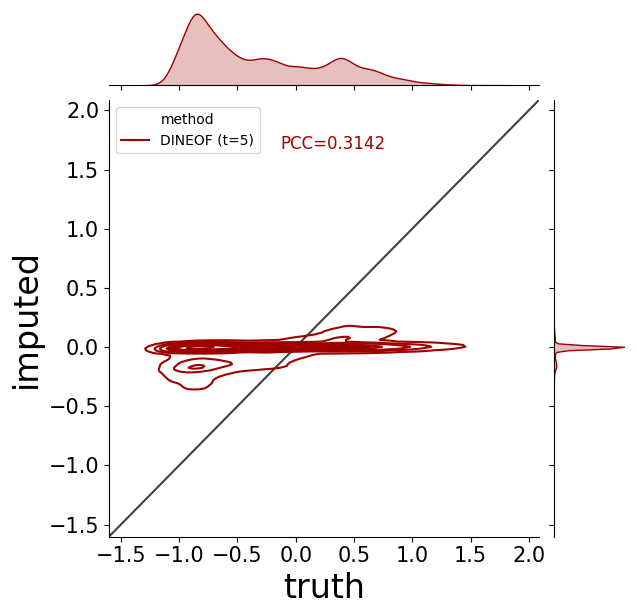

In [29]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(4, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=5
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=5)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 15:00:12.555 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 23: 3.539193494361825e-05, 9.682029485702515e-06
2025-06-03 15:00:12.699 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 21: 7.153443584684283e-05, 9.207979019265622e-06
2025-06-03 15:00:12.722 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 0: 9.557592761666456e-08, 9.557592761666456e-08
2025-06-03 15:00:12.844 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 19: 4.859522596234456e-05, 8.525963494321331e-06


Text(0.4, 0.92, 'PCC=0.4232')

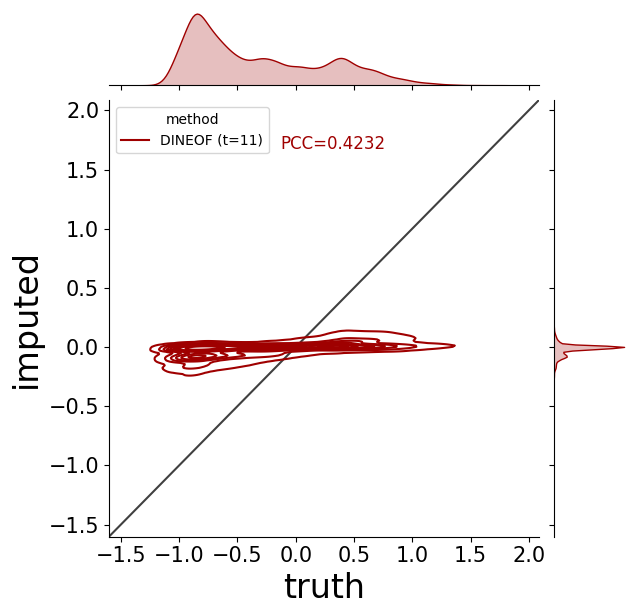

In [30]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=11
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = model.predict()
imputed_data_list.append(imputed_data[:,46//t*t-46:])
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=11)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 15:01:38.668 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 50: 0.00020601184223778546, 9.623632649891078e-06
2025-06-03 15:01:39.226 | INFO     | model.dineof:_fit:103 - Error/Relative Error at iteraion 45: 0.00015742632967885584, 9.525800123810768e-06


Text(0.4, 0.92, 'PCC=0.3728')

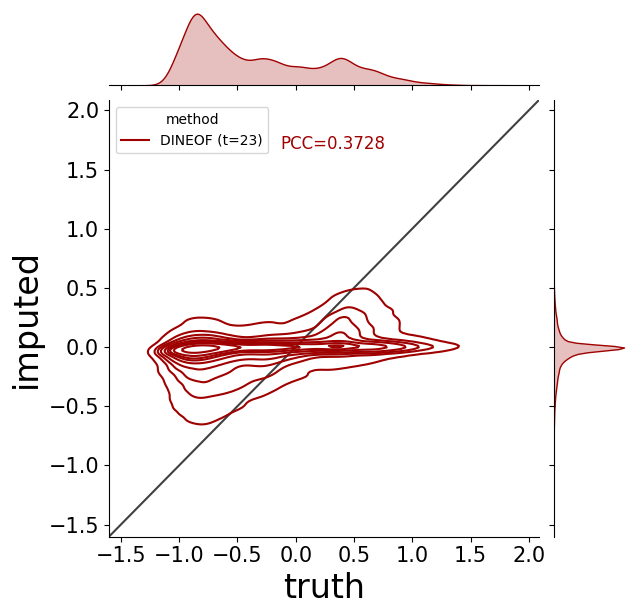

In [31]:
# DINEOF
from einops import rearrange
from model.dineof import DINEOF
model = DINEOF(10, [60, 96, config.in_len], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

t=23
tmp_data = torch.where(cond_mask_image.cpu()==0, float("nan"), datas_image.cpu())
tmp_data = rearrange(tmp_data, "b t c h w -> (b h) (w c) t")
tmp_data = tmp_data.cpu().numpy()

imputed_data_list = []

for i in range(46//t):
    model.fit(tmp_data[:,:,i*t:(i+1)*t])
    imputed_data = model.predict()
    imputed_data_list.append(imputed_data)
imputed_data = np.concatenate(imputed_data_list, axis=-1)
imputed_data = rearrange(imputed_data, "(b h w c) t->b t c h w", b=1, t=datas_image.shape[1], c=1, h=datas_image.shape[-2], w=datas_image.shape[-1])

imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=23)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")

2025-06-03 15:03:01.977 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 68: 0.0002469733590260148, 7.116614142432809e-06
2025-06-03 15:03:02.033 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 53: 0.00028734200168401003, 9.937997674569488e-06
2025-06-03 15:03:02.098 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 62: 0.000163619639351964, 9.96104790829122e-06
2025-06-03 15:03:02.169 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 68: 0.00018983388144988567, 9.617462637834251e-06
2025-06-03 15:03:02.228 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 57: 0.00013680299161933362, 9.737603249959648e-06
2025-06-03 15:03:02.305 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 74: 0.00017466569261159748, 9.627037798054516e-06
2025-06-03 15:03:02.369 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative E

Text(0.4, 0.92, 'PCC=0.3533')

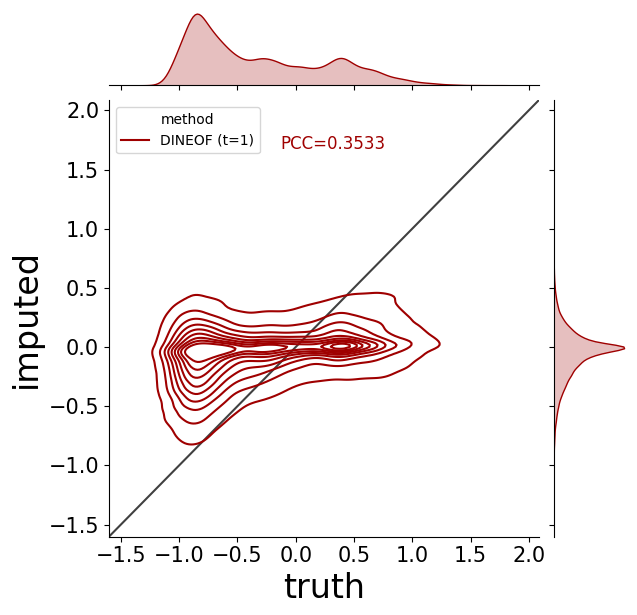

In [32]:
from einops import rearrange
from model.dineof_per_step import DINEOF
model = DINEOF(10, [60, 96], keep_non_negative_only=False)
is_sea = np.load("./data/PRE/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,60,96)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['DINEOF (t=1)' for i in range(imputed_dineof.shape[0])])
data = {'truth': truth.numpy(),
        'imputed':imputed_dineof,
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylim(ypoints)
# plt.legend()
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")